# This file is for testing the camera calibraiont pipeline

In [145]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from pathlib import Path

In [146]:
def is_geometrically_consistent(corners, pattern_size, threshold=0.3):
    if corners is None:
        return False
        
    cols, rows = pattern_size
    
    # The number of detected corners must match the expected number
    if corners.shape[0] != rows * cols:
        return False

    # Reshape the corners into a 2D grid for easy distance calculations
    # Shape becomes (rows, cols, 2)
    grid_points = corners.reshape(rows, cols, 2)

    # Calculate distances between horizontally adjacent corners
    h_diffs = np.linalg.norm(grid_points[:, 1:] - grid_points[:, :-1], axis=2)

    # Calculate distances between vertically adjacent corners
    v_diffs = np.linalg.norm(grid_points[1:, :] - grid_points[:-1, :], axis=2)

    # Combine all adjacent distances into a single array
    all_distances = np.concatenate((h_diffs.flatten(), v_diffs.flatten()))

    if all_distances.size == 0:
        return False  # Should not happen for boards > 1x1

    mean_dist = np.mean(all_distances)
    std_dev = np.std(all_distances)

    # The core validation logic: Is the standard deviation of distances
    # acceptably small compared to the average distance?
    is_consistent = (std_dev / mean_dist) < threshold
    
    if not is_consistent:
        print(f"  [REJECTED] Geometric check failed. Ratio: {std_dev / mean_dist:.3f} > {threshold}")

    return is_consistent

In [147]:
def is_near(corners_1, corners_2):
    mid_1 = int(np.floor(len(corners_1) / 2))
    mid_2 = int(np.floor(len(corners_2) / 2))

    mid_1 = [int(np.mean(corners_1[:, 0, 0])), int(np.mean(corners_1[:, 0, 1]))]
    mid_2 = [int(np.mean(corners_2[:, 0, 0])), int(np.mean(corners_2[:, 0, 1]))]

    if (np.abs(mid_1[0] - mid_2[0]) < 100 and 
        np.abs(mid_1[1] - mid_2[1]) < 100):
        return True
    else:
        return False

In [ ]:
# Define the chessboard dimensions for *each* type of chessboard you are using
# If you have multiple identical chessboards, you only need one definition.

square_size = 0.1 # m

chessboard_sizes = {
    'board1': (7, 11),  # eg big one on the left
    'board2': (5, 7), #  eg smaller ones in the middle for example
    'board3': (7, 5), # eg same as the prev one but on the side
    'board4': (5, 7), # this is to detect the very right board
}
square_sizes = {
    'board1': square_size, # in your chosen unit
    'board2': square_size,
    'board3': square_size,
    'board4': square_size,
}

# Prepare object points for each board type
objp_templates = {}
for name, size in chessboard_sizes.items():
    objp = np.zeros((size[0] * size[1], 3), np.float32)
    objp[:, :2] = np.mgrid[0:size[0], 0:size[1]].T.reshape(-1, 2) * square_sizes[name]
    objp_templates[name] = objp


raw_path = "../data/34759_final_project_raw/"
left_raw_path = raw_path + "calib/image_02/data/"
right_raw_path = raw_path + "calib/image_03/data/"

left_images = sorted(glob.glob(left_raw_path + '*.png'))
right_images = sorted(glob.glob(right_raw_path + '*.png'))

img = cv2.imread(left_images[0])
img2 = cv2.imread(right_images[0])
fig = plt.figure(figsize=(12, 12))
#fig = plt.imshow(img)
#fig = plt.imshow(img2)
#plt.show()



if len(left_images) != len(right_images):
    print("Error: Number of left and right images do not match!")
else:
    print("Image loading success")

Image loading success


<Figure size 1200x1200 with 0 Axes>

In [149]:
# OpenCV col, row, x, y

poly_left_manual = np.array(
                [[350, 180],  # top-left
                [490, 180],  # top-right
                [490, 330],  # bottom-right
                [350, 330]], # bottom-left
                dtype=np.int32,
            ).reshape((-1, 1, 2))

poly_right_manual = np.array(
                [[300, 180],  # top-left
                [410, 180],  # top-right
                [410, 330],  # bottom-right
                [300, 330]], # bottom-left
                dtype=np.int32,
            ).reshape((-1, 1, 2))

midband_left_manual = np.array(
                [[0, 160],  # top-left
                [1400, 160],  # top-right
                [1400, 370],  # bottom-right
                [0, 370]], # bottom-left
                dtype=np.int32,
            ).reshape((-1, 1, 2))

midband_right_manual = np.array(
                [[0, 160],  # top-left
                [1400, 160],  # top-right
                [1400, 370],  # bottom-right
                [0, 370]], # bottom-left
                dtype=np.int32,
            ).reshape((-1, 1, 2))

leftband_left_manual = np.array(
                [[0, 0],  # top-left
                [1320, 0],  # top-right
                [1320, 1200],  # bottom-right
                [0, 1200]], # bottom-left
                dtype=np.int32,
            ).reshape((-1, 1, 2))

leftband_right_manual = np.array(
                [[0, 0],  # top-left
                [1320, 0],  # top-right
                [1320, 1200],  # bottom-right
                [0, 1200]], # bottom-left
                dtype=np.int32,
            ).reshape((-1, 1, 2))



In [ ]:
iteration = 0
flags = cv2.CALIB_CB_EXHAUSTIVE | cv2.CALIB_CB_ACCURACY | cv2.CALIB_CB_NORMALIZE_IMAGE

all_objpoints = []
all_imgpoints_left = []
all_imgpoints_right = []

filtered_images_left = []
filtered_images_right = []

poly_left_mask = np.array(1)
poly_right_mask = np.array(1)

debug_path = 'debug/'
debug_counter = 0

once = 0


for name, size in chessboard_sizes.items():
    

    for i in range(len(left_images) - 0):
        iteration = 0
        # loop over every image
        img_left = cv2.imread(left_images[i])
        img_right = cv2.imread(right_images[i])
            

        # Preprocessing
        gray_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY) 
        gray_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)


        # Histrogram equalization
        gray_left = cv2.equalizeHist(gray_left)
        gray_right = cv2.equalizeHist(gray_right)
        '''
        '''

        # Sharpening
        blurred_left = cv2.GaussianBlur(gray_left, (5, 5), 0)
        blurred_right = cv2.GaussianBlur(gray_right, (5, 5), 0)

        sharpened_unsharp_left = cv2.addWeighted(gray_left, 1.5, blurred_left, -0.8, 0)
        sharpened_unsharp_right = cv2.addWeighted(gray_right, 1.5, blurred_right, -0.8, 0)

        gray_left = sharpened_unsharp_left
        gray_right = sharpened_unsharp_right

        if not (name == 'board1'):
            # Mask big board for this type
            gray_left = cv2.fillPoly(gray_left, [poly_left_mask], color=(0, 0, 0))
            gray_right = cv2.fillPoly(gray_right, [poly_right_mask], color=(0, 0, 0))

            gray_left = cv2.fillPoly(gray_left, [poly_left_manual], color=(0, 0, 0))
            gray_right = cv2.fillPoly(gray_right, [poly_right_manual], color=(0, 0, 0))

            flags = cv2.CALIB_CB_EXHAUSTIVE | cv2.CALIB_CB_ACCURACY | cv2.CALIB_CB_NORMALIZE_IMAGE
        if name == 'board3':
            # Mask midband for this one, as we are trying to get the ones on the edge
            gray_left = cv2.fillPoly(gray_left, [midband_left_manual], color=(0, 0, 0))
            gray_right = cv2.fillPoly(gray_right, [midband_right_manual], color=(0, 0, 0))

            flags = cv2.CALIB_CB_EXHAUSTIVE | cv2.CALIB_CB_ACCURACY | cv2.CALIB_CB_NORMALIZE_IMAGE

            #fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,16))
            #ax.imshow(gray_left, cmap='gray')
        if name == 'board4':
            # Mask leftband so that the very right one can be detected hopefully
            gray_left = cv2.fillPoly(gray_left, [leftband_left_manual], color=(0, 0, 0))
            gray_right = cv2.fillPoly(gray_right, [leftband_right_manual], color=(0, 0, 0))
            flags = cv2.CALIB_CB_EXHAUSTIVE | cv2.CALIB_CB_NORMALIZE_IMAGE
            '''
            '''
            brightness = 0 
            contrast = 1.6 

            gray_left = cv2.addWeighted(gray_left, contrast, np.zeros(gray_left.shape, gray_left.dtype), 0, brightness)
            gray_right = cv2.addWeighted(gray_right, contrast, np.zeros(gray_right.shape, gray_right.dtype), 0, brightness)

            #fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,16))
            #ax.imshow(gray_left, cmap='gray')



        # Contrast and brightness
        '''
        brightness = 5 
        contrast = 1.2 

        gray_left = cv2.addWeighted(gray_left, contrast, np.zeros(gray_left.shape, gray_left.dtype), 0, brightness)
        gray_right = cv2.addWeighted(gray_right, contrast, np.zeros(gray_right.shape, gray_right.dtype), 0, brightness)
        '''

        '''
        '''

        # Histrogram equalization
        #gray_left = cv2.equalizeHist(gray_left)
        #gray_right = cv2.equalizeHist(gray_right)

        if once == 1:
            once = 0
            fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,16))
            ax.imshow(gray_left, cmap='gray')

        #continue

        repeat = True
        max_loops = 0
        while repeat and max_loops < 12:
            max_loops += 1

            found_left, corners_left = cv2.findChessboardCornersSB(gray_left, size, flags=flags) 
            found_right, corners_right = cv2.findChessboardCornersSB(gray_right, size, flags=flags) 

            '''
            if ((is_geometrically_consistent(corners_left, size) == False or is_geometrically_consistent(corners_right, size) == False) and
                (found_left and found_right)):
                
                pass
                # Wrong chessboards found

                xs = corners_left[:, 0, 0]
                ys = corners_left[:, 0, 1]

                x_min = int(np.floor(xs.min()) - 20)
                x_max = int(np.ceil(xs.max()) + 20)
                y_min = int(np.floor(ys.min()) - 20)
                y_max = int(np.ceil(ys.max()) + 20)

                poly = np.array(
                    [[x_min, y_min],  # top-left
                    [x_max, y_min],  # top-right
                    [x_max, y_max],  # bottom-right
                    [x_min, y_max]], # bottom-left
                    dtype=np.int32,
                ).reshape((-1, 1, 2))

                gray_left = cv2.fillPoly(img, [poly], color=(0, 0, 0))

                img = cv2.fillPoly(img, [poly], color=(0, 0, 0))
                #img = cv2.drawChessboardCorners(img, size, corners_left, found_left)

                continue
            '''

            if found_left and found_right and len(corners_left) == len(corners_right) and is_near(corners_left, corners_right):
                print(f'{name}, img_n: {i}, iter: {iteration}, Same board located')
            else:
                repeat = False
                print(f'{name}, img_n: {i}, iter: {iteration}, Same board NOT located')
                pass
                continue
            #print(f'{name}, iter: {i}   left found {found_left}, right found {found_right}, Corners left: {len(corners_left)}, corners right: {len(corners_right)}') 

            if found_left and found_right:
                # Check corner correspondence
                y_errors = np.abs(corners_left[:, 0, 1] - corners_right[:, 0, 1])
                x_disparity = corners_left[:, 0, 0] - corners_right[:, 0, 0]
    
                print(f"  Y-error: mean={y_errors.mean():.2f}, max={y_errors.max():.2f}")
                print(f"  X-disparity: mean={x_disparity.mean():.2f}, std={x_disparity.std():.2f}")
    
                if y_errors.max() > 10.0:  # Should be very small for rectified stereo
                    print("  [WARNING] Large Y-error suggests wrong board pair!")


            # Add both obj and image points
            all_objpoints.append(objp_templates[name])
            all_imgpoints_left.append(corners_left)
            all_imgpoints_right.append(corners_right)

            print(f'{name}, img_n: {i}, iter: {iteration}, points appended')

            xs = corners_left[:, 0, 0]
            ys = corners_left[:, 0, 1]

            x_min = int(np.floor(xs.min()) - 20)
            x_max = int(np.ceil(xs.max()) + 20)
            y_min = int(np.floor(ys.min()) - 20)
            y_max = int(np.ceil(ys.max()) + 20)

            poly_left = np.array(
                [[x_min, y_min],  # top-left
                [x_max, y_min],  # top-right
                [x_max, y_max],  # bottom-right
                [x_min, y_max]], # bottom-left
                dtype=np.int32,
            ).reshape((-1, 1, 2))


            xs = corners_right[:, 0, 0]
            ys = corners_right[:, 0, 1]

            x_min = int(np.floor(xs.min()) - 20)
            x_max = int(np.ceil(xs.max()) + 20)
            y_min = int(np.floor(ys.min()) - 20)
            y_max = int(np.ceil(ys.max()) + 20)

            poly_right = np.array(
                [[x_min, y_min],  # top-left
                [x_max, y_min],  # top-right
                [x_max, y_max],  # bottom-right
                [x_min, y_max]], # bottom-left
                dtype=np.int32,
            ).reshape((-1, 1, 2))

            if name == 'board1':
                poly_left_mask = poly_left
                poly_right_mask = poly_right

            gray_left = cv2.fillPoly(gray_left, [poly_left], color=(0, 0, 0))
            gray_right = cv2.fillPoly(gray_right, [poly_right], color=(0, 0, 0))

            #log_left = gray_left.copy()
            #log_right = gray_right.copy()

            log_left = cv2.drawChessboardCorners(gray_left, size, corners_left, found_left)
            log_right = cv2.drawChessboardCorners(gray_right, size, corners_right, found_right)

            saved_image = np.hstack([log_left, log_right])
            cv2.imwrite(debug_path + name + '_' + 'img' + '_' + str(i) + '_' + 'iter' + '_' + str(iteration) + ".png", saved_image)
            debug_counter += 1

            img = cv2.fillPoly(img, [poly_left], color=(0, 0, 0))
            img = cv2.drawChessboardCorners(img, size, corners_left, found_left)

            iteration += 1
            #plt.imshow(img)
            #repeat = False


#plt.imshow(img)

print(f'Len objpoints: {len(all_objpoints)}')
print(f'Len imgpoints_left: {len(all_imgpoints_left)}')
print(f'Len imgpoints_right: {len(all_imgpoints_right)}')

board1, img_n: 0, iter: 0, Same board located
  Y-error: mean=11.35, max=19.70
  X-disparity: mean=68.95, std=1.44
  [WARNING] Large Y-error suggests wrong board pair!
board1, img_n: 0, iter: 0, points appended
board1, img_n: 0, iter: 1, Same board NOT located
board1, img_n: 1, iter: 0, Same board located
  Y-error: mean=11.36, max=19.68
  X-disparity: mean=68.95, std=1.44
  [WARNING] Large Y-error suggests wrong board pair!
board1, img_n: 1, iter: 0, points appended
board1, img_n: 1, iter: 1, Same board NOT located
board1, img_n: 2, iter: 0, Same board located
  Y-error: mean=11.36, max=19.70
  X-disparity: mean=68.94, std=1.44
  [WARNING] Large Y-error suggests wrong board pair!
board1, img_n: 2, iter: 0, points appended
board1, img_n: 2, iter: 1, Same board NOT located
board1, img_n: 3, iter: 0, Same board located
  Y-error: mean=11.35, max=19.70
  X-disparity: mean=68.94, std=1.44
  [WARNING] Large Y-error suggests wrong board pair!
board1, img_n: 3, iter: 0, points appended
board1

In [ ]:
img_shape = img.shape
img_shape = (img_shape[1], img_shape[0])

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_COUNT, 60, 1e-8)

ret_l, mtx_l, dist_l, rvecs_l, tvecs_l = cv2.calibrateCamera(
    all_objpoints, 
    all_imgpoints_left, 
    img_shape, 
    None, 
    None, 
    flags=0,
    criteria=criteria,
)
print(f"Left camera RMS reprojection error: {ret_l:.4f}")

ret_r, mtx_r, dist_r, rvecs_r, tvecs_r = cv2.calibrateCamera(
    all_objpoints, 
    all_imgpoints_right, 
    img_shape, 
    None, 
    None, 
    flags=0,
    criteria=criteria,
)
print(f"Right camera RMS reprojection error: {ret_r:.4f}")


# Stereo calibration
stereocalib_criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 100, 1e-5)
stereo_flags = cv2.CALIB_ZERO_DISPARITY| cv2.CALIB_FIX_INTRINSIC #| cv2.CALIB_FIX_PRINCIPAL_POINT #cv2.CALIB_USE_INTRINSIC_GUESS | cv2.CALIB_ZERO_DISPARITY#| cv2.CALIB_FIX_INTRINSIC #| cv2.CALIB_RATIONAL_MODEL

ret_stereo, mtx_l, dist_l, mtx_r, dist_r, R, T, E, F = cv2.stereoCalibrate(
        all_objpoints,
        all_imgpoints_left,
        all_imgpoints_right,
        mtx_l, dist_l,
        mtx_r, dist_r,
        img_shape,
        flags=stereo_flags,
        criteria=stereocalib_criteria,
        )

print("\n--- Calibration Results ---")
print(f"Stereo Reprojection Error: {ret_stereo}")
print("\nLeft Camera Matrix:\n", mtx_l)
print("\nLeft Distortion Coeffs:\n", dist_l)
print("\nRight Camera Matrix:\n", mtx_r)
print("\nRight Distortion Coeffs:\n", dist_r)
print("\nRotation Matrix (R):\n", R)
print("\nTranslation Vector (T):\n", T)

Left camera RMS reprojection error: 0.0712
Right camera RMS reprojection error: 0.0650

--- Calibration Results ---
Stereo Reprojection Error: 0.2661823526544937

Left Camera Matrix:
 [[990.54279248   0.         683.62700852]
 [  0.         990.04449073 278.94829591]
 [  0.           0.           1.        ]]

Left Distortion Coeffs:
 [[-3.67497084e-01  4.13810215e-01  4.17168231e-04 -2.23502645e-03
  -4.57329160e-01]]

Right Camera Matrix:
 [[939.09699311   0.         692.92619815]
 [  0.         945.47266784 268.42592101]
 [  0.           0.           1.        ]]

Right Distortion Coeffs:
 [[-3.42502670e-01  2.40074946e-01 -2.52471525e-04  1.55403226e-03
  -1.36452084e-01]]

Rotation Matrix (R):
 [[ 0.99950091  0.01952748 -0.02483177]
 [-0.01933429  0.9997811   0.00799613]
 [ 0.02498248 -0.00751204  0.99965966]]

Translation Vector (T):
 [[-0.55931108]
 [ 0.01640622]
 [ 0.05854456]]


In [161]:
# Overwriting stereo calib, since the stereo reprojection error is incredibly high
'''
mtx_l = np.array([[9.812178e+02, 0.000000e+00, 6.900000e+02],
                    [0.000000e+00, 9.758994e+02, 2.471364e+02],
                    [0.000000e+00, 0.000000e+00, 1.000000e+00]])

dist_l = np.array([[-3.791375e-01],
                     [2.148119e-01],
                     [1.227094e-03],
                     [2.343833e-03],
                     [-7.910379e-02]])

mtx_r = np.array([[9.863925e+02, 0.000000e+00, 7.020000e+02],
                    [0.000000e+00, 9.821423e+02, 2.588854e+02],
                    [0.000000e+00, 0.000000e+00, 1.000000e+00]])

dist_r = np.array([[-3.673556e-01],
                   [1.862563e-01],
                   [8.496128e-05],
                   [1.699076e-04],
                   [-5.822524e-02]])

R = np.array([[9.993552e-01, 1.830187e-02, -3.089048e-02],
              [-1.855578e-02, 9.997962e-01, -7.952999e-03],
              [3.073863e-02, 8.521068e-03, 9.994911e-01]])
  
T = np.array([[-5.370000e-01],
              [4.509875e-03],
              [-1.198621e-02]])

'''

'\nmtx_l = np.array([[9.812178e+02, 0.000000e+00, 6.900000e+02],\n                    [0.000000e+00, 9.758994e+02, 2.471364e+02],\n                    [0.000000e+00, 0.000000e+00, 1.000000e+00]])\n\ndist_l = np.array([[-3.791375e-01],\n                     [2.148119e-01],\n                     [1.227094e-03],\n                     [2.343833e-03],\n                     [-7.910379e-02]])\n\nmtx_r = np.array([[9.863925e+02, 0.000000e+00, 7.020000e+02],\n                    [0.000000e+00, 9.821423e+02, 2.588854e+02],\n                    [0.000000e+00, 0.000000e+00, 1.000000e+00]])\n\ndist_r = np.array([[-3.673556e-01],\n                   [1.862563e-01],\n                   [8.496128e-05],\n                   [1.699076e-04],\n                   [-5.822524e-02]])\n\nR = np.array([[9.993552e-01, 1.830187e-02, -3.089048e-02],\n              [-1.855578e-02, 9.997962e-01, -7.952999e-03],\n              [3.073863e-02, 8.521068e-03, 9.994911e-01]])\n  \nT = np.array([[-5.370000e-01],\n          

In [162]:
# a good run
'''
Left camera RMS reprojection error: 0.0733
Right camera RMS reprojection error: 0.0647

--- Calibration Results ---
Stereo Reprojection Error: 4.471686304013107

Left Camera Matrix:
 [[989.19304129   0.         682.79257278]
 [  0.         989.97360791 274.55679514]
 [  0.           0.           1.        ]]

Left Distortion Coeffs:
 [[-3.67659013e-01  4.21865750e-01  4.54309641e-04 -1.26682442e-03
  -4.66088973e-01]]

Right Camera Matrix:
 [[935.25156003   0.         689.55209051]
 [  0.         942.10595566 269.71020461]
 [  0.           0.           1.        ]]

Right Distortion Coeffs:
 [[-0.34059232  0.23294887 -0.00036349  0.0020644  -0.12958179]]

Rotation Matrix (R):
 [[ 0.99904642  0.02146716 -0.03801851]
 [-0.02130258  0.99976189  0.0047289 ]
 [ 0.03811098 -0.0039145   0.99926585]]

Translation Vector (T):
 [[-0.44756223]
 [-0.00128274]
 [ 0.01222457]]

'''

'\nLeft camera RMS reprojection error: 0.0733\nRight camera RMS reprojection error: 0.0647\n\n--- Calibration Results ---\nStereo Reprojection Error: 4.471686304013107\n\nLeft Camera Matrix:\n [[989.19304129   0.         682.79257278]\n [  0.         989.97360791 274.55679514]\n [  0.           0.           1.        ]]\n\nLeft Distortion Coeffs:\n [[-3.67659013e-01  4.21865750e-01  4.54309641e-04 -1.26682442e-03\n  -4.66088973e-01]]\n\nRight Camera Matrix:\n [[935.25156003   0.         689.55209051]\n [  0.         942.10595566 269.71020461]\n [  0.           0.           1.        ]]\n\nRight Distortion Coeffs:\n [[-0.34059232  0.23294887 -0.00036349  0.0020644  -0.12958179]]\n\nRotation Matrix (R):\n [[ 0.99904642  0.02146716 -0.03801851]\n [-0.02130258  0.99976189  0.0047289 ]\n [ 0.03811098 -0.0039145   0.99926585]]\n\nTranslation Vector (T):\n [[-0.44756223]\n [-0.00128274]\n [ 0.01222457]]\n\n'

In [154]:
# the best run yet, this will be used
'''
Left camera RMS reprojection error: 0.0712
Right camera RMS reprojection error: 0.0650

--- Calibration Results ---
Stereo Reprojection Error: 0.2661823526544937

Left Camera Matrix:
 [[990.54279248   0.         683.62700852]
 [  0.         990.04449073 278.94829591]
 [  0.           0.           1.        ]]

Left Distortion Coeffs:
 [[-3.67497084e-01  4.13810215e-01  4.17168231e-04 -2.23502645e-03
  -4.57329160e-01]]

Right Camera Matrix:
 [[939.09699311   0.         692.92619815]
 [  0.         945.47266784 268.42592101]
 [  0.           0.           1.        ]]

Right Distortion Coeffs:
 [[-3.42502670e-01  2.40074946e-01 -2.52471525e-04  1.55403226e-03
  -1.36452084e-01]]

Rotation Matrix (R):
 [[ 0.99950091  0.01952748 -0.02483177]
 [-0.01933429  0.9997811   0.00799613]
 [ 0.02498248 -0.00751204  0.99965966]]

Translation Vector (T):
 [[-0.55931108]
 [ 0.01640622]
 [ 0.05854456]]
'''

'''
'''

mtx_l = np.array([[990.54279248, 0, 683.62700852],
                    [0, 990.04449073, 278.94829591],
                    [0, 0, 1]])

dist_l = np.array([[-3.67497084e-01],
                     [4.13810215e-01],
                     [4.17168231e-04],
                     [-2.23502645e-03],
                     [-4.57329160e-01]])

mtx_r = np.array([[939.09699311, 0, 692.92619815],
                    [0, 945.47266784, 268.42592101],
                    [0, 0, 1]])

dist_r = np.array([[-3.42502670e-01],
                    [2.40074946e-01],
                    [-2.52471525e-04],
                    [1.55403226e-03],
                    [-1.36452084e-01]])

R = np.array([[0.99950091, 0.01952748, -0.02483177],
              [-0.01933429,  0.9997811, 0.00799613],
              [0.02498248, -0.00751204, 0.99965966]])
  
T = np.array([[-0.55931108],
              [0.01640622],
              [0.05854456]])

'''
'''

'\n'

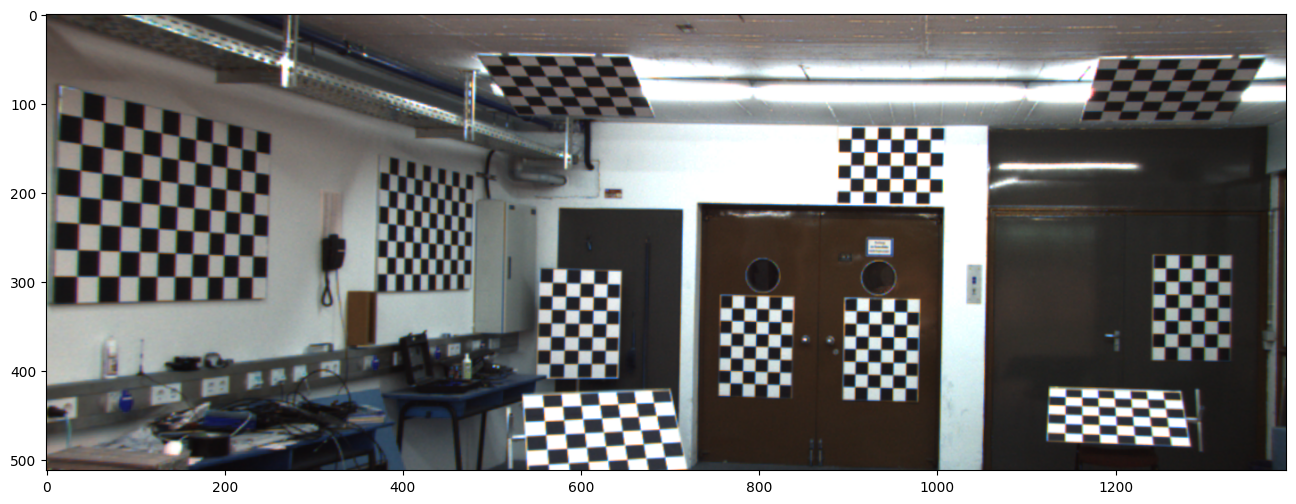

In [163]:
R1, R2, P1, P2, Q, valid_roi_left, valid_roi_right = cv2.stereoRectify(
    mtx_l, dist_l,
    mtx_r, dist_r,
    img_shape,
    R, T,
    alpha=0.0 # alpha=0 crops the image to show only valid pixels, alpha=1 shows all pixels
)
    
# Create the undistortion and rectification maps for each camera
map_l_x, map_l_y = cv2.initUndistortRectifyMap(mtx_l, dist_l, R1, P1, img_shape, cv2.CV_32FC1)
map_r_x, map_r_y = cv2.initUndistortRectifyMap(mtx_r, dist_r, R2, P2, img_shape, cv2.CV_32FC1)

img_l_demo = cv2.imread(left_images[0])
img_r_demo = cv2.imread(right_images[0])

rectified_l = cv2.remap(img_l_demo, map_l_x, map_l_y, cv2.INTER_LINEAR)
rectified_r = cv2.remap(img_r_demo, map_r_x, map_r_y, cv2.INTER_LINEAR)
    
x1, y1, w1, h1 = valid_roi_left
x2, y2, w2, h2 = valid_roi_right
cropped_l  = rectified_l[y1:y1+h1, x1:x1+w1]
cropped_r = rectified_r[y2:y2+h2, x2:x2+w2]

        
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 16))
ax = plt.imshow(rectified_l)
#ax = plt.imshow(cropped_l)
plt.show()

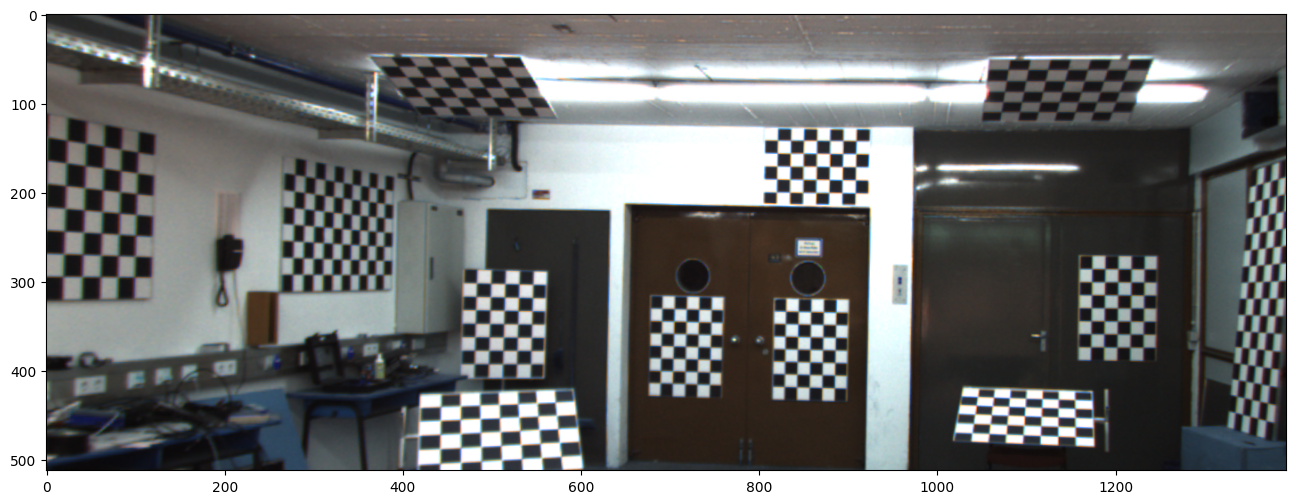

In [164]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 16))
ax = plt.imshow(rectified_r)
#ax = plt.imshow(cropped_r)
plt.show()